<a href="https://colab.research.google.com/github/Telemaco019/flower_recognition/blob/master/notebooks/tf_flowers_reduced_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup environment


In [0]:
#import plaidml.keras
#import os

# For using AMD GPU
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#plaidml.keras.install_backend()

In [1]:
# Switch version to 2.x (works only in Colab)
%tensorflow_version 2.x 

TensorFlow 2.x selected.


In [2]:
!pip install efficientnet

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"telemaco019","key":"79d96455b9e4240082e508a612dec15b"}'}

In [0]:
!rm ~/.kaggle -rf
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!cat ~/.kaggle/kaggle.json

{"username":"telemaco019","key":"79d96455b9e4240082e508a612dec15b"}

In [6]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 97% 437M/450M [00:06<00:00, 57.7MB/s]
100% 450M/450M [00:06<00:00, 69.2MB/s]


In [7]:
!unzip /content/flowers-recognition.zip 

Archive:  /content/flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.

# Constants and imports


In [8]:
import glob
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from functools import partial 
import os 
import time

import pandas as pd
import seaborn

Using TensorFlow backend.


In [9]:
import tensorflow as tf
print(tf.__version__)

DATASET_ROOT_DIR = '/content/flowers'

DAISY_DIR = 'daisy'
DANDELION_DIR = 'dandelion'
ROSE_DIR = 'rose'
SUNFLOWER_DIR = 'sunflower'
TULIP_DIR = 'tulip'

DATA_DIRS = [DAISY_DIR, DANDELION_DIR, ROSE_DIR, SUNFLOWER_DIR, TULIP_DIR]

BATCH_SIZE = 32
IMG_SIZE = 224
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE

2.1.0-rc1


# Load and prepare dataset

In [0]:
def load_data(dataset_directory): 
    images = []
    labels = []
    complete_directory = "{}/{}".format(DATASET_ROOT_DIR, dataset_directory)
    print('Loading data from: {}/'.format(complete_directory))

    for img_file in tqdm(os.listdir(complete_directory)):
        path = os.path.join(complete_directory, img_file)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if not img is None: 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            images.append(np.array(img))
            labels.append(str(dataset_directory))
    
    return (np.array(images), np.array(labels))

In [0]:
encoder = LabelEncoder()
def encode_labels(string_labels):
    return encoder.fit_transform(string_labels)


In [0]:
def load_dataset():
    X = []
    Z = []
  
    for directory in DATA_DIRS:
        (data, labels_strings) = load_data(directory) 
        X.append(data)
        Z.append(labels_strings)
        
    # Squeeze into 1d array
    X = np.concatenate(X, axis=0)
    Z = np.concatenate(Z, axis=0)
    
    # Encode labels
    Y = encode_labels(Z)
    
    return (X,Y)

In [13]:
(X,Y) = load_dataset()

  2%|▏         | 13/769 [00:00<00:05, 129.53it/s]

Loading data from: /content/flowers/daisy/


  4%|▍         | 43/1055 [00:00<00:02, 418.44it/s]

Loading data from: /content/flowers/dandelion/


  5%|▌         | 41/784 [00:00<00:01, 407.92it/s]

Loading data from: /content/flowers/rose/


  5%|▍         | 36/734 [00:00<00:01, 358.11it/s]

Loading data from: /content/flowers/sunflower/


  4%|▍         | 40/984 [00:00<00:02, 397.23it/s]

Loading data from: /content/flowers/tulip/


100%|██████████| 984/984 [00:02<00:00, 390.69it/s]


In [14]:
print("Total number of images: {}".format(len(X)))
print("Total number of labels: {}".format(len(Y)))

Total number of images: 4323
Total number of labels: 4323


**Split train, valid and test datasets**

In [83]:
from sklearn import model_selection

X_train, X_test_valid, Y_train, Y_test_valid = model_selection.train_test_split(X,Y, train_size=0.2)
X_valid, X_test, Y_valid, Y_test = model_selection.train_test_split(X_test_valid, Y_test_valid, train_size=0.4)

print("Training dataset size: {}".format(len(X_train)))
print("Validation dataset size: {}".format(len(X_valid)))
print("Test dataset size: {}".format(len(X_test)))

Training dataset size: 864
Validation dataset size: 1383
Test dataset size: 2076


# Utility functions


## Plot

In [0]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,10))
  class_names = encoder.inverse_transform(label_batch)
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title("Class: {}".format(class_names[n]))
      plt.axis('off')

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:
def plot_curves(history): 
  plt.figure(figsize=(18,6))
  plt.subplot(1,2,1)
  plot_accuracy_curves(history)
  plt.subplot(1,2,2)
  plot_loss_curves(history)

In [0]:
def plot_correct_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  correct_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] == Y_test[i]:
      correct_pred_indexes.append(i)

  img_batch = [X_test[i] for i in correct_pred_indexes]
  lbl_batch = [Y_pred[i] for i in correct_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Correct predictions: {} out of {}".format(len(correct_pred_indexes), len(Y_test)))

In [0]:
def plot_wrong_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  wrong_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] != Y_test[i]:
      wrong_pred_indexes.append(i)

  img_batch = [X_test[i] for i in wrong_pred_indexes]
  lbl_batch = [Y_pred[i] for i in wrong_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Wrong predictions: {} out of {}".format(len(wrong_pred_indexes), len(Y_test)))

## Training

In [0]:
def get_early_stopping_callbacks(patience, checkpoint_file_path):
  # Early stopping + save best model callbacks 
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
  callbacks = [checkpoint_cb, early_stopping_cb]
  return callbacks

In [0]:
def train_model(model, epochs, callbacks):
  STEP_SIZE_TRAIN=len(X_train)//BATCH_SIZE
  STEP_SIZE_VALID=len(X_valid)//BATCH_SIZE

  print("Batch size: {}".format(BATCH_SIZE))
  print("Training dataset size: {} - Training steps per epoch: {}".format(len(X_train), STEP_SIZE_TRAIN))
  print("Validation dataset size: {} - Validation steps per epoch: {}".format(len(X_valid), STEP_SIZE_TRAIN))

  history = model.fit(train_dataset,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_dataset,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = callbacks)
  
  return history

## Metrics

In [0]:
def show_scores(model):
  start = time.time()
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()
  end = time.time()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='macro')

  plt.figure(figsize = (10,7))
  norm_cm = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred, normalize='true')
  norm_cm_df = pd.DataFrame(norm_cm, index=encoder.classes_, columns=encoder.classes_)
  seaborn.heatmap(norm_cm_df, annot=True)

  print('|Average prediction time: {:.2f} ms'.format((end-start)/len(Y_test)*1000))
  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

## Preprocessing



In [0]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

In [0]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [0]:
def preprocess(image, label, augmentation=False):
  if augmentation:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
    cropped_image = tf.image.random_flip_up_down(cropped_image)
    cropped_image = tf.image.random_brightness(cropped_image, max_delta=0.2)
  else:
    cropped_image = central_crop(image)
  
  resized_image = tf.image.resize(cropped_image, [IMG_SIZE, IMG_SIZE])
  normalized_image = tf.image.per_image_standardization(resized_image)
  
  return normalized_image,label

In [0]:
def apply_cache(labeled_dataset, cache=True, batch_size=BATCH_SIZE):
  # Load the dataset once and keep it in memory.
  # Use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory (in this case a file will be used as cache).
  if isinstance(cache, str):
    labeled_dataset = labeled_dataset.cache(cache)
  else:
    labeled_dataset = labeled_dataset.cache()

  return labeled_dataset

In [0]:
def batch_and_prefetch(labeled_dataset, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE):
  return labeled_dataset.batch(batch_size).prefetch(buffer_size)

# Create Tensorflow datasets

In [0]:
unprocessed_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
unprocessed_valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
unprocessed_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [0]:
cached_train_dataset = apply_cache(unprocessed_train_dataset)
cached_valid_dataset = apply_cache(unprocessed_valid_dataset)

In [0]:
test_dataset = unprocessed_test_dataset.map(partial(preprocess, augmentation=False), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE).batch(1)

valid_dataset = cached_valid_dataset.map(partial(preprocess, augmentation=False))
valid_dataset = batch_and_prefetch(valid_dataset)

train_dataset = cached_train_dataset.shuffle(buffer_size=1000).repeat().map(partial(preprocess, augmentation=False), num_parallel_calls=AUTOTUNE)
train_dataset = batch_and_prefetch(train_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


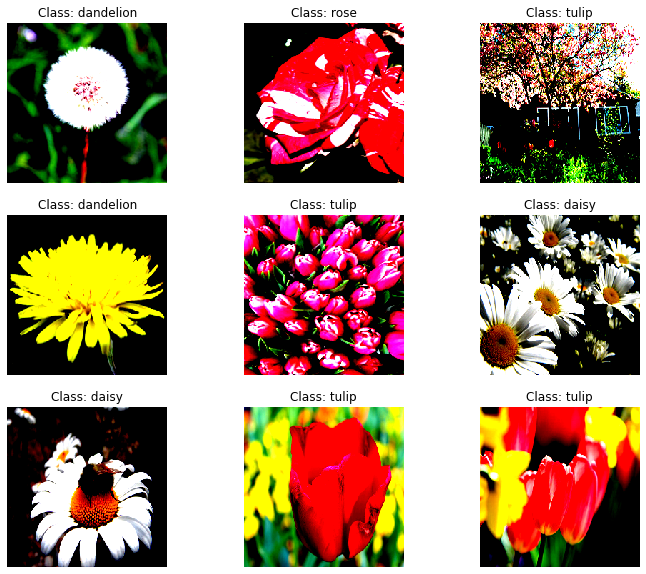

In [100]:
a, b = next(iter(train_dataset))
show_batch(a,b)

# Custom Deep CNN

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [102]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 128)      

In [103]:
epochs = 30
callbacks = get_early_stopping_callbacks(3, 'tf_flowers_base.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 864 - Training steps per epoch: 27
Validation dataset size: 1383 - Validation steps per epoch: 27
Train for 27 steps, validate for 43 steps
Epoch 1/30
27/27 [==============================] - 4s 150ms/step - loss: 1.4738 - accuracy: 0.3426 - val_loss: 1.2908 - val_accuracy: 0.4281
Epoch 2/30
27/27 [==============================] - 3s 104ms/step - loss: 1.1733 - accuracy: 0.4931 - val_loss: 1.2440 - val_accuracy: 0.4557
Epoch 3/30
27/27 [==============================] - 3s 117ms/step - loss: 1.0297 - accuracy: 0.5995 - val_loss: 1.1893 - val_accuracy: 0.5094
Epoch 4/30
27/27 [==============================] - 3s 103ms/step - loss: 0.9184 - accuracy: 0.6308 - val_loss: 1.1758 - val_accuracy: 0.5211
Epoch 5/30
27/27 [==============================] - 3s 103ms/step - loss: 0.8009 - accuracy: 0.6944 - val_loss: 1.1791 - val_accuracy: 0.5211
Epoch 6/30
27/27 [==============================] - 3s 98ms/step - loss: 0.6760 - accuracy: 0.7616 - val_loss: 1

|Average prediction time: 2.40 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.52|0.52|0.52
|Macro|0.55|0.52|0.50


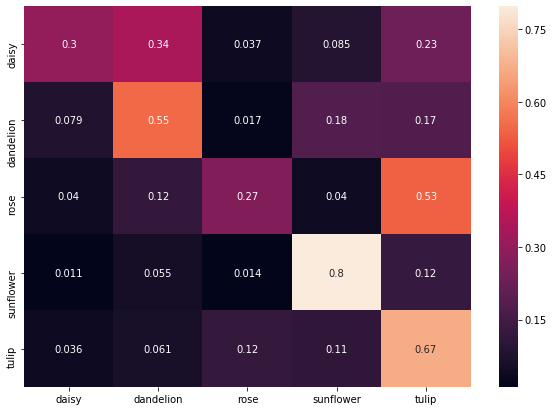

In [104]:
show_scores(model)

# Feature extraction with Dense hidden layer and GlobalMaxPooling

> Indented block




In [105]:
import efficientnet.tfkeras as efn

# Use layers=tf.keras.layers in order to fix Keras bug. See https://github.com/keras-team/keras/pull/9965
conv_base = efn.EfficientNetB1(weights="imagenet", include_top=False, pooling='avg', input_shape=(IMG_SIZE,IMG_SIZE,3), layers=tf.keras.layers)

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

Model: "efficientnet-b1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [107]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 1280)              6575232   
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 6405      
Total params: 6,581,637
Trainable params: 6,405
Non-trainable params: 6,575,232
_________________________________________________________________


In [108]:
epochs = 30
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 864 - Training steps per epoch: 27
Validation dataset size: 1383 - Validation steps per epoch: 27
Train for 27 steps, validate for 43 steps
Epoch 1/30
27/27 [==============================] - 12s 446ms/step - loss: 1.6357 - accuracy: 0.2477 - val_loss: 1.5410 - val_accuracy: 0.3285
Epoch 2/30
27/27 [==============================] - 4s 160ms/step - loss: 1.4760 - accuracy: 0.3738 - val_loss: 1.4052 - val_accuracy: 0.4506
Epoch 3/30
27/27 [==============================] - 4s 160ms/step - loss: 1.3443 - accuracy: 0.4699 - val_loss: 1.2939 - val_accuracy: 0.5523
Epoch 4/30
27/27 [==============================] - 4s 161ms/step - loss: 1.2373 - accuracy: 0.5602 - val_loss: 1.1944 - val_accuracy: 0.6134
Epoch 5/30
27/27 [==============================] - 4s 158ms/step - loss: 1.1408 - accuracy: 0.6319 - val_loss: 1.1092 - val_accuracy: 0.6621
Epoch 6/30
27/27 [==============================] - 4s 157ms/step - loss: 1.0573 - accuracy: 0.6782 - val_loss:

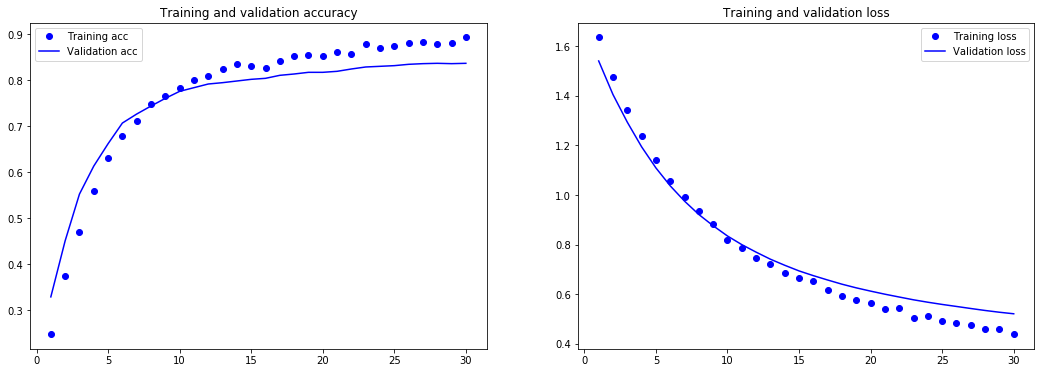

|Average prediction time: 13.05 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.86|0.86|0.86
|Macro|0.86|0.86|0.86


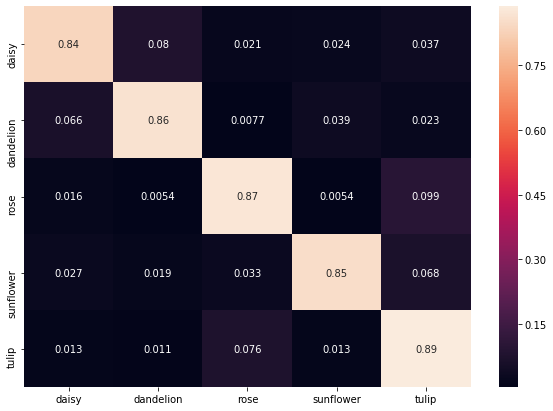

In [109]:
plot_curves(history)
show_scores(model)

# Fine tuning

In [0]:
for layer in conv_base.layers:
  if layer.name.startswith('block7') or layer.name.startswith('top'):
    layer.trainable = True

In [111]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 1280)              6575232   
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 6405      
Total params: 6,581,637
Trainable params: 2,699,397
Non-trainable params: 3,882,240
_________________________________________________________________


In [114]:
epochs = 100
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 864 - Training steps per epoch: 27
Validation dataset size: 1383 - Validation steps per epoch: 27
Train for 27 steps, validate for 43 steps
Epoch 1/100
27/27 [==============================] - 5s 175ms/step - loss: 0.7982 - accuracy: 0.7905 - val_loss: 0.5466 - val_accuracy: 0.8314
Epoch 2/100
27/27 [==============================] - 4s 147ms/step - loss: 0.7208 - accuracy: 0.8229 - val_loss: 0.5587 - val_accuracy: 0.8270
Epoch 3/100
27/27 [==============================] - 4s 146ms/step - loss: 0.6847 - accuracy: 0.8391 - val_loss: 0.5670 - val_accuracy: 0.8219
Epoch 4/100
27/27 [==============================] - 4s 146ms/step - loss: 0.6399 - accuracy: 0.8461 - val_loss: 0.5721 - val_accuracy: 0.8198
Epoch 5/100
27/27 [==============================] - 4s 146ms/step - loss: 0.6294 - accuracy: 0.8623 - val_loss: 0.5734 - val_accuracy: 0.8190
Epoch 6/100
27/27 [==============================] - 4s 146ms/step - loss: 0.5661 - accuracy: 0.8727 - val_

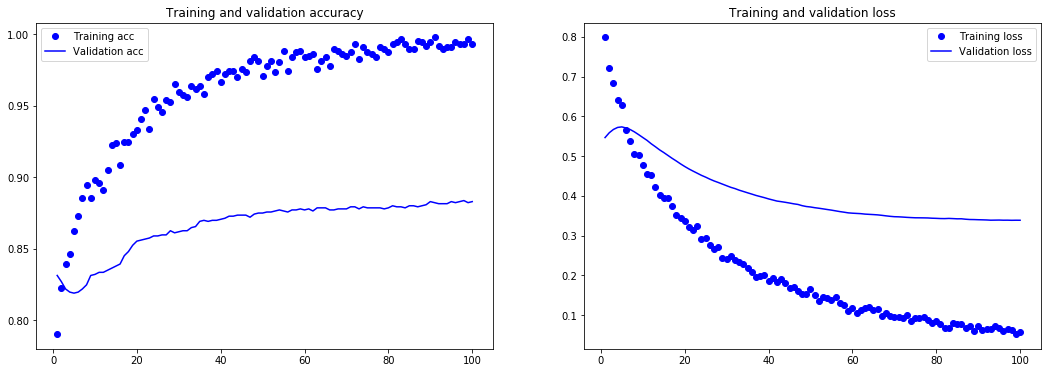

|Average prediction time: 12.39 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.90|0.90|0.90
|Macro|0.90|0.89|0.90


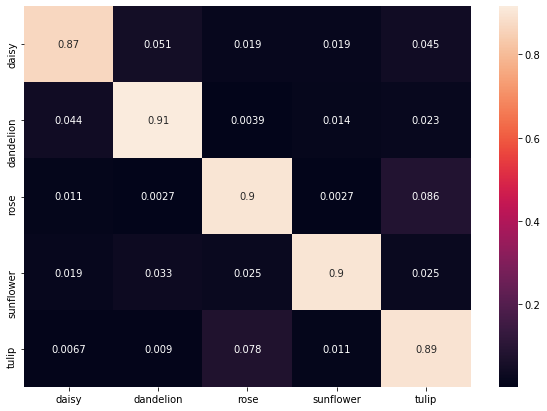

In [115]:
plot_curves(history)
show_scores(model)

# Visualize predictions on test set

Correct predictions: 1860 out of 2076


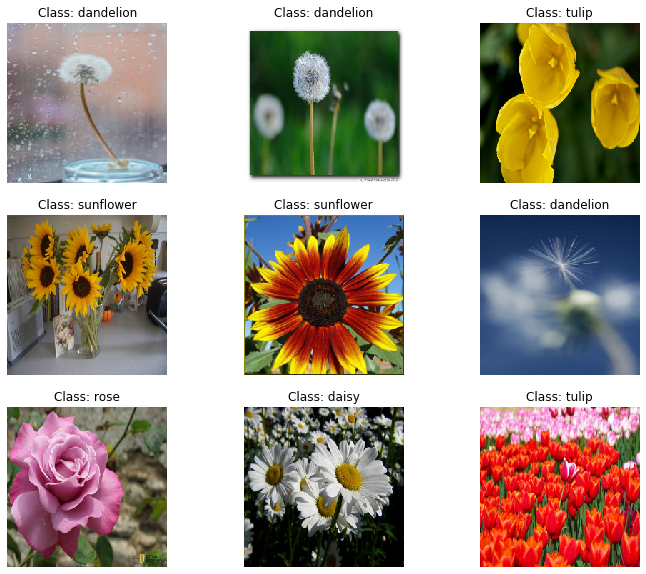

In [116]:
plot_correct_predictions(model)

Wrong predictions: 216 out of 2076


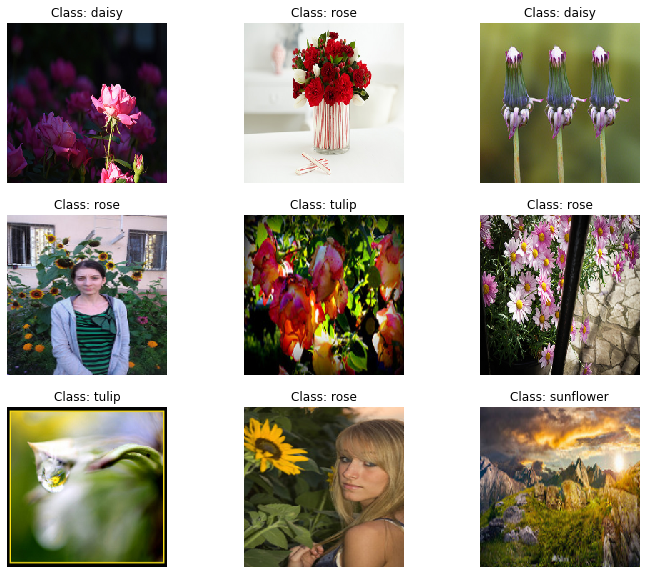

In [117]:
plot_wrong_predictions(model)